<h1><center><font size="6">Post-Augmentation Modeling Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Augmentations through ImageDataGenerator</a>
    - <a href='#21'>Generating the Datasets</a>   
    - <a href='#22'>Constructing and Compiling the Model</a>   
    - <a href='#23'>Defining Callbacks</a>   
    - <a href='#24'>Training the Model</a>  
- <a href='#3'>Augmentations through Albumentations</a> 
- <a href='#4'>Starting CNN Model</a>
    - <a href='#41'>Generating the Datasets</a>   
    - <a href='#42'>Constructing the Model</a>   
    - <a href='#43'>Compiling the Model</a>   
    - <a href='#44'>Defining Callbacks</a>   
    - <a href='#45'>Training the Model</a>   
    - <a href='#46'>Evaluating the Model</a>
    - <a href='#47'>Predicting on Holdout Set</a>    
    - <a href='#48'>Saving the Model</a>  
- <a href='#5'>Final CNN Model</a>
    - <a href='#51'>Generating the Datasets</a>   
    - <a href='#52'>Constructing the Model</a>   
    - <a href='#53'>Compiling the Model</a>   
    - <a href='#54'>Defining Callbacks</a>   
    - <a href='#55'>Training the Model</a>   
    - <a href='#56'>Evaluating the Model</a>
    - <a href='#57'>Saving the Model</a>    
    - <a href='#58'>Predicting on Holdout Set</a>  


# <a id='1'>Importing Packages</a>

In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from utils import *

%reload_ext autoreload
%autoreload 2


# <a id='2'>Augmentation through ImageDataGenerator</a>


## <a id='21'>Generating the Datasets</a>
 

In [9]:
# generating augmentations through ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

# assigning paths
train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

# generating datasets for training, validation, and testing
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## <a id='22'>Constructing and Compiling the Model</a>


In [6]:
# create model
def create_model(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

model = create_model((224, 224, 3))

# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

## <a id='23'>Defining Callbacks</a>


In [82]:
# define callbacks
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

## <a id='24'>Training the Model</a>


In [ ]:
# train model
history = model.fit_generator(generator = train_generator,
                             epochs = 20,
                             steps_per_epoch = len(train_generator),
                             callbacks = [earlyStopping, mcp_save],
                             validation_data = val_generator)

# <a id='3'>Augmentations through Albumentations</a>

I only left one iteration of the model with the original imbalanced dataset, but any model run could only produce 0.0 or 1.0 for any of the metrics.  I considered upsampling the minority class through 

# <a id='4'>Starting CNN Model</a>

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics in my initial development of different models and hence able to differentiate between the minority and majority class.

## <a id='41'>Generating the Datasets</a>
 

In [2]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='42'>Constructing the Model</a>


In [3]:
# build model similar to VGG16
def cnn_model_1(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

model2 = cnn_model_1((256, 256, 3))

## <a id='43'>Compiling the Model</a>


In [4]:
# Compile Model
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve = 'PR'), keras.metrics.Precision(), keras.metrics.Recall()])

## Defining Callbacks

In [5]:
# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
filepath = "../logs/log_cnn1/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_cnn1/log.csv')
log_dir = "../logs/log_cnn1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Training the Model

In [39]:
# train model
history2 = model2.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
428/428 [==============================] - 4777s 11s/step - loss: 8.8718 - accuracy: 0.8544 - auc_2: 0.8364 - auc_3: 0.9188 - precision_1: 0.9082 - recall_1: 0.9019 - val_loss: 0.3825 - val_accuracy: 0.8672 - val_auc_2: 0.8709 - val_auc_3: 0.9703 - val_precision_1: 0.8790 - val_recall_1: 0.9816
Epoch 2/20
428/428 [==============================] - 5585s 13s/step - loss: 0.2607 - accuracy: 0.9152 - auc_2: 0.9433 - auc_3: 0.9755 - precision_1: 0.9244 - recall_1: 0.9681 - val_loss: 0.2516 - val_accuracy: 0.9017 - val_auc_2: 0.9282 - val_auc_3: 0.9818 - val_precision_1: 0.9691 - val_recall_1: 0.9155
Epoch 3/20
428/428 [==============================] - 6295s 15s/step - loss: 0.1787 - accuracy: 0.9325 - auc_2: 0.9688 - auc_3: 0.9870 - precision_1: 0.9420 - recall_1: 0.9706 - val_loss: 0.2644 - val_accuracy: 0.9323 - val_auc_2: 0.9272 - val_auc_3: 0.9847 - val_precision_1: 0.9601 - val_recall_1: 0.9616
Epoch 4/20
428/428 [==============================] - 6213s 14s/step - loss: 0.

## Evaluating the Model

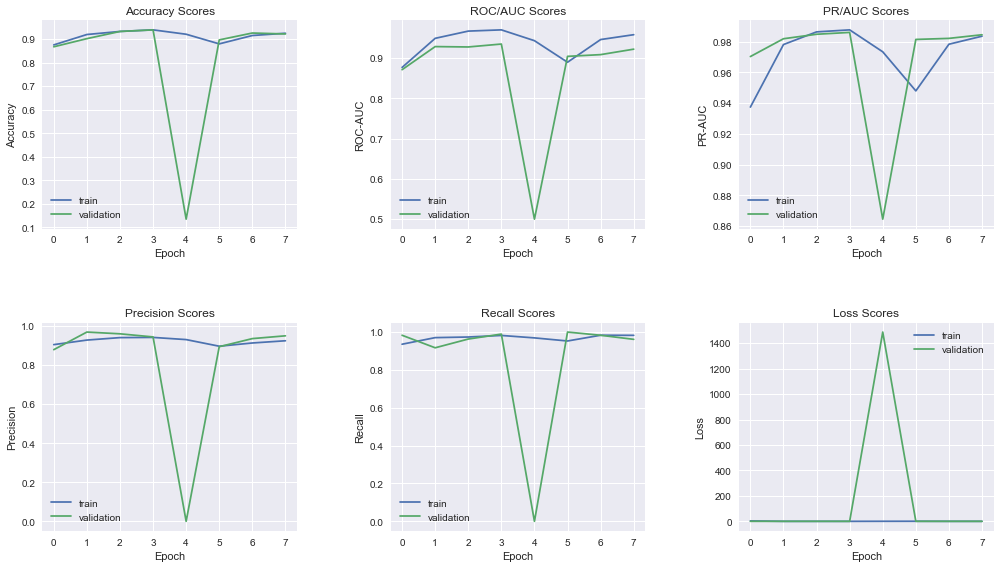

In [41]:
# evaluate model by displaying metrics with visualization
plt.style.use('seaborn')
sixplot(history2, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [42]:
# display metrics in dataframe
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc_2,auc_3,precision_1,recall_1,val_loss,val_accuracy,val_auc_2,val_auc_3,val_precision_1,val_recall_1
0,3.386384,0.875146,0.876426,0.937389,0.904762,0.934307,0.382473,0.867198,0.870877,0.970253,0.878955,0.981567
1,0.239563,0.919298,0.948659,0.978052,0.928072,0.969074,0.251605,0.901726,0.928165,0.981831,0.969106,0.915515
2,0.181951,0.932310,0.966591,0.986287,0.940717,0.972340,0.264395,0.932271,0.927231,0.984745,0.960123,0.961598
3,0.166070,0.939035,0.969670,0.987603,0.941708,0.980599,0.189592,0.938911,0.934490,0.985943,0.944200,0.987711
4,0.626118,0.920468,0.942820,0.973327,0.930550,0.967730,1487.413696,0.135458,0.500000,0.864542,0.000000,0.000000
5,0.831648,0.879532,0.889329,0.947926,0.896633,0.951402,0.253626,0.896414,0.903926,0.981379,0.894085,0.998464
6,0.222603,0.915058,0.945623,0.978268,0.913168,0.981752,0.226076,0.925631,0.908218,0.982067,0.935578,0.981567
7,0.196400,0.924708,0.957674,0.983486,0.924525,0.981176,0.224488,0.921647,0.921764,0.984422,0.949848,0.960061


In [43]:
hist_df_2.to_csv("../data/history_cnn1.csv")

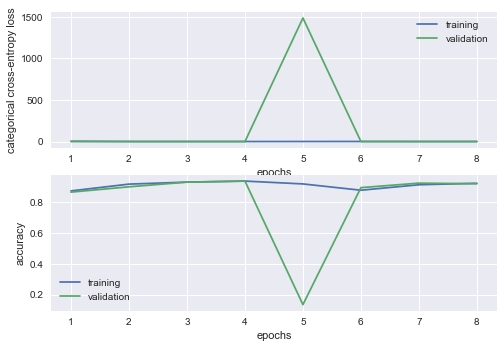

In [44]:
# visualization for loss and accuracy
train_val_metrics(8, history2)

## Predicting on Holdout Set

In [47]:
# get testing loss and accuracy
X_test, y_test = next(test_generator)
score = model2.evaluate(X_test, y_test, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

24/24 [==============================] - 88s 4s/step - loss: 0.2408 - accuracy: 0.9031 - auc_2: 0.9126 - auc_3: 0.9842 - precision_1: 0.9392 - recall_1: 0.9493
loss: 0.24075591564178467
accuracy: 0.9030544757843018


In [ ]:
test_generator.reset()
prob2 = model2.predict_generator(test_generator,
                                 steps = STEP_SIZE_TEST,
                                 verbose = 1)
y_true = test_generator.classes
y_pred_2 = prob2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

In [ ]:
# get testing accuracy and loss
score = model3.evaluate_generator(test_generator, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

## Saving Model

In [ ]:
model2.save('../models/cnn_v1')

# Final CNN Model



## Generating the Datasets

In [3]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## Constructing the Model

In [4]:
# construct model
def cnn2(input_shape):
    return Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(3, 3)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

model3 = cnn2((256, 256, 3))

## Compiling the Model

In [5]:
# compile model
model3.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

## Defining Callbacks

In [19]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
# earlyStopping = EarlyStopping(monitor = 'val_loss', 
#                               verbose = 1, 
#                               mode = 'min', 
#                               patience = 4)
filepath = "../logs/log_cnn2/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_cnn2/log.csv')
log_dir = "../logs/log_cnn2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Training the Model

In [20]:
# train model
history3 = model3.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 2147s 5s/step - loss: 0.1309 - accuracy: 0.9515 - auc: 0.9786 - auc_1: 0.9909 - precision: 0.9522 - recall: 0.9857 - val_loss: 0.2937 - val_accuracy: 0.9415 - val_auc: 0.9102 - val_auc_1: 0.9772 - val_precision: 0.9366 - val_recall: 1.0000

Epoch 00001: saving model to ../logs/log_cnn2/model.01-0.29.hdf5
Epoch 2/20
427/427 [==============================] - 2145s 5s/step - loss: 0.1311 - accuracy: 0.9557 - auc: 0.9781 - auc_1: 0.9902 - precision: 0.9552 - recall: 0.9883 - val_loss: 0.3307 - val_accuracy: 0.9481 - val_auc: 0.9347 - val_auc_1: 0.9872 - val_precision: 0.9580 - val_recall: 0.9831

Epoch 00002: saving model to ../logs/log_cnn2/model.02-0.33.hdf5
Epoch 3/20
427/427 [==============================] - 2179s 5s/step - loss: 0.1220 - accuracy: 0.9576 - auc: 0.9810 - auc_1: 0.9915 - precision: 0.9564 - recall: 0.9894 - val_loss: 0.2877 - val_accuracy: 0.9309 - val_auc: 0.9415 - val_auc_1: 0.9869 - val_precision: 0.9517 - val_r

## Evaluating the Model

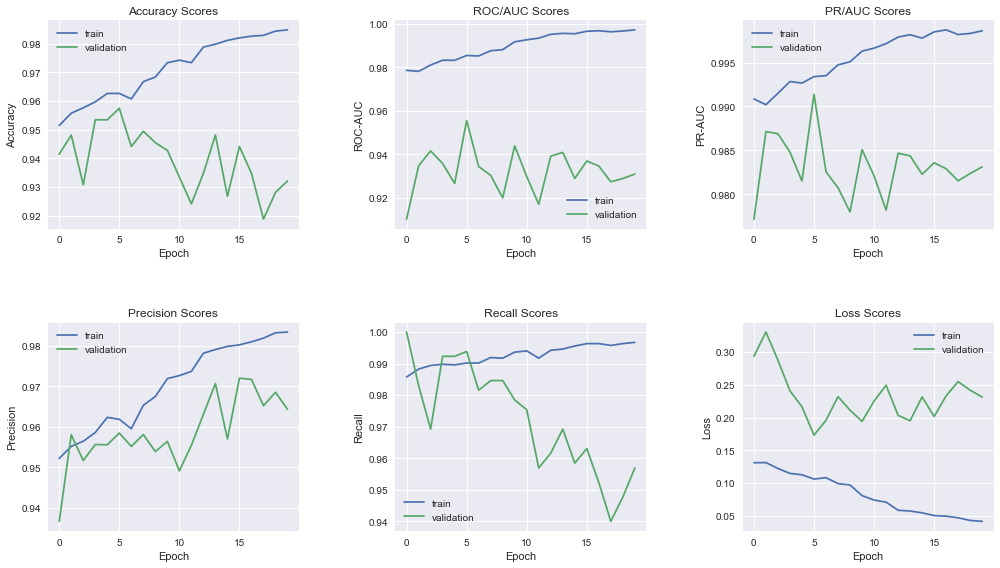

In [21]:
# create visualization of metrics
plt.style.use('seaborn')
sixplot(history3, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [22]:
# create dataframe of metrics
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall,lr
0,0.130871,0.951495,0.978567,0.990859,0.952186,0.985747,0.293684,0.941489,0.910189,0.977197,0.936599,1.000000,0.001000
1,0.131070,0.955744,0.978112,0.990203,0.955163,0.988258,0.330746,0.948138,0.934668,0.987154,0.958021,0.983077,0.001000
2,0.122031,0.957649,0.981006,0.991503,0.956425,0.989405,0.287677,0.930851,0.941538,0.986908,0.951662,0.969231,0.001000
3,0.114582,0.959701,0.983225,0.992838,0.958598,0.989794,0.240846,0.953457,0.935750,0.984812,0.955621,0.992320,0.001000
4,0.112415,0.962632,0.983180,0.992664,0.962345,0.989597,0.216395,0.953457,0.926584,0.981533,0.955556,0.992308,0.001000
5,0.105909,0.962632,0.985399,0.993392,0.961862,0.990185,0.172995,0.957447,0.955505,0.991395,0.958457,0.993846,0.001000
6,0.107915,0.960727,0.985179,0.993505,0.959530,0.990185,0.195817,0.944149,0.934358,0.982579,0.955157,0.981567,0.001000
7,0.098933,0.966735,0.987564,0.994733,0.965343,0.991915,0.231918,0.949468,0.930309,0.980771,0.958084,0.984615,0.001000
8,0.096778,0.968347,0.988094,0.995081,0.967512,0.991723,0.211299,0.945479,0.919956,0.978011,0.953869,0.984639,0.001000
9,0.080546,0.973329,0.991685,0.996287,0.971929,0.993644,0.194074,0.942819,0.943854,0.985096,0.956391,0.978462,0.000500


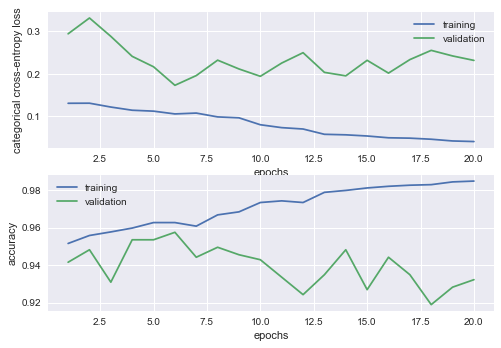

In [23]:
# plot accuracy and loss
plt.style.use('seaborn')
train_val_metrics(20, history3)

## Saving the Model

In [24]:
model3.save('../models/cnn_final')

INFO:tensorflow:Assets written to: ../models/cnn_final/assets


## Predicting on Holdout Set

In [ ]:
test_generator.reset()
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [31]:
# get testing accuracy and loss
score = model3.evaluate_generator(test_generator, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

753/753 [==============================] - 124s 164ms/step - loss: 0.1862 - accuracy: 0.9402 - auc: 0.9380 - auc_1: 0.9857 - precision: 0.9647 - recall: 0.9662
loss: 0.18618255853652954
accuracy: 0.9402390718460083


## Confusion Matrix

In [26]:
test_generator.reset()
prob3 = model3.predict_generator(test_generator,
                                 steps = STEP_SIZE_TEST,
                                 verbose = 1)

753/753 [==============================] - 128s 170ms/step


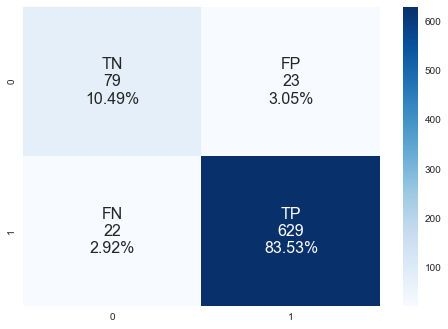

In [27]:
y_true = test_generator.classes
y_pred_3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred_3)

# Analysis

The final CNN model is able not only to differentiate between the two classes, but is able to achieve high metrics across the board in terms of ROC-AUC and PR-AUC scores.